# ML DEFRA Data Preparation - ALL 37 POLLUTANTS

**Extended version:** Processes all 37 pollutants (6 regulatory + 31 VOCs) across all DEFRA stations for comprehensive model training.

## What this notebook does

1. Loads cleaned data from the optimised folder.
2. Includes ALL 37 pollutants (regulatory + VOCs).
3. Combines all measurements into a single dataset.
4. Creates temporal features (hour, day, month).
5. Creates sequences for ML training.

## Why all 37 pollutants?

DEFRA monitors additional volatile organic compounds (VOCs) that LAQN doesn't have. This notebook uses all available data to see if more pollutant features improve predictions.

## Output path:

Data will be saved to: `data/defra/ml_prep_all_37/`

In [1]:
# starting with adding mandotary and very helpful python modules below.
import pandas as pd
import numpy as np
import os
from pathlib import Path

#save section
import joblib

#visilisation section
import matplotlib.pyplot as plt

# preprocessing libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
# DEFRA prep file paths
base_dir = Path.cwd().parent.parent / "data" / "defra"
project_root = Path.cwd() / "ml_prep_defra_all_37.ipynb"

# DEFRA optimised data path
optimised_path = base_dir / "optimised"

# Output path - 37 pollutant version (all DEFRA pollutants)
output_path = base_dir / "ml_prep_all_37"
output_path.mkdir(parents=True, exist_ok=True)

# Visualisation output path
visualisation_path = output_path / "visualisation"
visualisation_path.mkdir(parents=True, exist_ok=True)

print(f"Base directory: {base_dir}")
print(f"Data path: {optimised_path}")
print(f"Output path: {output_path}")
print(f"Path exists: {optimised_path.exists()}")

Base directory: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/defra
Data path: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/defra/optimised
Output path: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/defra/ml_prep_all_37
Path exists: True


In [3]:
# Define constants at top of notebook
n_past = 12
n_future = 1

## 1) Load DEFRA data

DEFRA structure is nested: `optimised/YEARmeasurements/Station_Name/Pollutant__YYYY_MM.csv`

In [4]:
def load_defra_data(optimised_path):
    """
    Function to load the optimised data files from the defra dataset.
    """
    optimised_path = Path(optimised_path)
    all_files = []
    file_count = 0
    
    year_folders = sorted([f for f in optimised_path.iterdir() 
                          if f.is_dir() and 'measurements' in f.name])
    
    print(f"Found {len(year_folders)} year folders")
    
    for year_dir in year_folders:
        year_file_count = 0
        station_folders = sorted([f for f in year_dir.iterdir() if f.is_dir()])
        
        for station_dir in station_folders:
            for csv_file in station_dir.glob("*.csv"):
                try:
                    df = pd.read_csv(csv_file)
                    all_files.append(df)
                    file_count += 1
                    year_file_count += 1
                except Exception as e:
                    print(f"Error reading {csv_file.name}: {e}")
        
        print(f"  Loaded {year_dir.name}: {year_file_count} files")
    
    if not all_files:
        raise ValueError(f"No CSV files found in {optimised_path}")
    
    combined_df = pd.concat(all_files, ignore_index=True)
    
    print(f"\n" + "="*40)
    print(f"Total files loaded: {file_count}")
    print(f"Total rows: {len(combined_df):,}")
    print(f"Columns: {list(combined_df.columns)}")
    
    return combined_df

In [5]:
# Load all DEFRA data
df_raw = load_defra_data(optimised_path)
df_raw.head()

Found 3 year folders
  Loaded 2023measurements: 1431 files
  Loaded 2024measurements: 1193 files
  Loaded 2025measurements: 939 files

Total files loaded: 3563
Total rows: 2,525,991
Columns: ['timestamp', 'value', 'timeseries_id', 'station_name', 'pollutant_name', 'pollutant_std', 'latitude', 'longitude']


,timestamp,value,timeseries_id,station_name,pollutant_name,pollutant_std,latitude,longitude
0,2023-09-01 00:00:00,26.966,4566,Borehamwood Meadow Park,Nitrogen oxides,NOx,51.661229,-0.27055
1,2023-09-01 01:00:00,27.349,4566,Borehamwood Meadow Park,Nitrogen oxides,NOx,51.661229,-0.27055
2,2023-09-01 02:00:00,22.567,4566,Borehamwood Meadow Park,Nitrogen oxides,NOx,51.661229,-0.27055
3,2023-09-01 04:00:00,17.021,4566,Borehamwood Meadow Park,Nitrogen oxides,NOx,51.661229,-0.27055
4,2023-09-01 05:00:00,23.141,4566,Borehamwood Meadow Park,Nitrogen oxides,NOx,51.661229,-0.27055


## 2) Rename columns to match LAQN format

In [6]:
# Rename columns to match LAQN format
df_raw = df_raw.rename(columns={
    'timestamp': '@MeasurementDateGMT',
    'value': '@Value',
    'pollutant_std': 'SpeciesCode',
    'station_name': 'SiteName'
})

# Create SiteCode from SiteName (replace spaces with underscores)
df_raw['SiteCode'] = df_raw['SiteName'].str.replace(' ', '_')

print(f"Renamed columns: {df_raw.columns.tolist()}")
df_raw.head()

Renamed columns: ['@MeasurementDateGMT', '@Value', 'timeseries_id', 'SiteName', 'pollutant_name', 'SpeciesCode', 'latitude', 'longitude', 'SiteCode']


,@MeasurementDateGMT,@Value,timeseries_id,SiteName,pollutant_name,SpeciesCode,latitude,longitude,SiteCode
0,2023-09-01 00:00:00,26.966,4566,Borehamwood Meadow Park,Nitrogen oxides,NOx,51.661229,-0.27055,Borehamwood_Meadow_Park
1,2023-09-01 01:00:00,27.349,4566,Borehamwood Meadow Park,Nitrogen oxides,NOx,51.661229,-0.27055,Borehamwood_Meadow_Park
2,2023-09-01 02:00:00,22.567,4566,Borehamwood Meadow Park,Nitrogen oxides,NOx,51.661229,-0.27055,Borehamwood_Meadow_Park
3,2023-09-01 04:00:00,17.021,4566,Borehamwood Meadow Park,Nitrogen oxides,NOx,51.661229,-0.27055,Borehamwood_Meadow_Park
4,2023-09-01 05:00:00,23.141,4566,Borehamwood Meadow Park,Nitrogen oxides,NOx,51.661229,-0.27055,Borehamwood_Meadow_Park


## 3) Handle DEFRA Missing Value Flags

In [7]:
def handle_flags(df, value_col='@Value'):
    """
    Replace DEFRA quality flags with NaN.
    """
    df = df.copy()
    
    flag_99 = (df[value_col] == -99).sum()
    flag_1 = (df[value_col] == -1).sum()
    negative = (df[value_col] < 0).sum()
    
    print(f"DEFRA quality flags found:")
    print(f"  -99 (maintenance): {flag_99:,} ({flag_99/len(df)*100:.2f}%)")
    print(f"  -1 (invalid): {flag_1:,} ({flag_1/len(df)*100:.2f}%)")
    print(f"  All negative values: {negative:,} ({negative/len(df)*100:.2f}%)")
    
    df[value_col] = df[value_col].replace([-99, -1], np.nan)
    df.loc[df[value_col] < 0, value_col] = np.nan
    
    remaining_neg = (df[value_col] < 0).sum()
    print(f"\nAfter cleaning: {remaining_neg} negative values remain.")
    
    return df

df_raw = handle_flags(df_raw)

DEFRA quality flags found:
  -99 (maintenance): 0 (0.00%)
  -1 (invalid): 0 (0.00%)
  All negative values: 0 (0.00%)

After cleaning: 0 negative values remain.


## 4) Data exploration - All 37 pollutants

In [8]:
date_col = '@MeasurementDateGMT'
value_col = '@Value'
site_col = 'SiteCode'
species_col = 'SpeciesCode'

df_raw[date_col] = pd.to_datetime(df_raw[date_col])

print(f"Unique sites: {df_raw[site_col].nunique()}")
print(f"Unique species: {df_raw[species_col].nunique()}")
print(f"\nDate range: {df_raw[date_col].min()} to {df_raw[date_col].max()}")
print(f"\nSpecies in data (all {df_raw[species_col].nunique()}):")
print(df_raw[species_col].value_counts())

Unique sites: 18
Unique species: 37

Date range: 2023-01-01 01:00:00 to 2025-11-09 23:00:00

Species in data (all 37):
SpeciesCode
NO2                326072
NO                 326061
NOx                325387
PM2.5              234748
PM10               227142
O3                 194333
SO2                 72928
CO                  48578
1,3,5-TMB           26649
i-Octane            26649
Benzene             26649
1,2,3-TMB           26649
Ethylbenzene        26649
Toluene             26649
o-Xylene            26649
n-Octane            26649
n-Heptane           26649
1,2,4-TMB           26649
Propane             26618
n-Pentane           26618
i-Pentane           26618
Ethene              26618
Propene             26618
Isoprene            26618
i-Hexane            26599
trans-2-Butene      26599
trans-2-Pentene     26599
n-Butane            26599
1-Butene            26599
i-Butane            26599
Ethane              26599
cis-2-Butene        26599
n-Hexane            26580
1-Pentene  

## 5) NO FILTERING - Keep All 37 Pollutants

Unlike the 6-pollutant version, we keep everything here.

In [9]:
# Keep all pollutants - no filtering
df_filtered = df_raw.copy()

print(f"Total rows: {len(df_filtered):,}")
print(f"Total pollutants: {df_filtered[species_col].nunique()}")

# Fix PM2.5 (remove dot) and clean special characters for column names
df_filtered['SpeciesCode'] = df_filtered['SpeciesCode'].str.replace('.', '', regex=False)
df_filtered['SpeciesCode'] = df_filtered['SpeciesCode'].str.replace(',', '_', regex=False)
df_filtered['SpeciesCode'] = df_filtered['SpeciesCode'].str.replace('-', '_', regex=False)

print(f"\nSpecies codes after cleaning: {df_filtered['SpeciesCode'].nunique()} unique")

Total rows: 2,525,991
Total pollutants: 37

Species codes after cleaning: 37 unique


## 6) Wide formatting

In [10]:
def wide_format(df, datetime_col, site_col, species_col, value_col):
    """
    Pivot data from long to wide format.
    """
    df = df.copy()
    df['site_species'] = df[site_col] + '_' + df[species_col]
    
    pivoted = df.pivot_table(
        index=datetime_col,
        columns='site_species',
        values=value_col,
        aggfunc='mean'
    )
    
    pivoted = pivoted.sort_index()
    
    print(f"Created wide format:")
    print(f"Timestamps: {len(pivoted):,}")
    print(f"Features (site-species): {len(pivoted.columns)}")
    print(f"Date range: {pivoted.index.min()} to {pivoted.index.max()}")
    
    return pivoted

In [11]:
df_wide = wide_format(df_filtered, date_col, site_col, species_col, value_col)
print("\nFirst 15 columns:")
print(list(df_wide.columns)[:15])
print(f"\nTotal columns: {len(df_wide.columns)}")
df_wide.head()

Created wide format:
Timestamps: 24,355
Features (site-species): 141
Date range: 2023-01-01 01:00:00 to 2025-11-09 23:00:00

First 15 columns:
['Borehamwood_Meadow_Park_NO', 'Borehamwood_Meadow_Park_NO2', 'Borehamwood_Meadow_Park_NOx', 'Borehamwood_Meadow_Park_PM10', 'Borehamwood_Meadow_Park_PM25', 'Camden_Kerbside_NO', 'Camden_Kerbside_NO2', 'Camden_Kerbside_NOx', 'Camden_Kerbside_PM10', 'Camden_Kerbside_PM25', 'Ealing_Horn_Lane_PM10', 'Haringey_Roadside_NO', 'Haringey_Roadside_NO2', 'Haringey_Roadside_NOx', 'London_Bexley_NO']

Total columns: 141


site_species,Borehamwood_Meadow_Park_NO,Borehamwood_Meadow_Park_NO2,Borehamwood_Meadow_Park_NOx,Borehamwood_Meadow_Park_PM10,Borehamwood_Meadow_Park_PM25,Camden_Kerbside_NO,Camden_Kerbside_NO2,Camden_Kerbside_NOx,Camden_Kerbside_PM10,Camden_Kerbside_PM25,...,London_Westminster_NOx,London_Westminster_O3,London_Westminster_PM25,Southwark_A2_Old_Kent_Road_NO,Southwark_A2_Old_Kent_Road_NO2,Southwark_A2_Old_Kent_Road_NOx,Southwark_A2_Old_Kent_Road_PM10,Tower_Hamlets_Roadside_NO,Tower_Hamlets_Roadside_NO2,Tower_Hamlets_Roadside_NOx
@MeasurementDateGMT,,,,,,,,,,,,,,,,,,,,,
2023-01-01 01:00:00,0.499,4.781,5.546,8.5,6.038,3.118,7.268,12.049,22.223,21.0,...,10.328,NaN,7.4,0.624,5.546,6.503,22.223,1.372,5.355,7.459
2023-01-01 02:00:00,0.374,5.164,5.737,8.0,5.189,2.994,9.563,14.152,8.696,3.0,...,8.606,NaN,7.4,0.499,4.973,5.737,10.628,1.247,4.781,6.694
2023-01-01 03:00:00,0.249,2.678,3.060,8.8,4.811,1.746,5.546,8.224,14.493,5.0,...,7.459,NaN,6.4,0.748,4.399,5.546,12.561,1.746,6.311,8.989
2023-01-01 04:00:00,0.249,2.486,2.869,11.3,5.849,1.247,4.973,6.885,17.392,7.0,...,6.120,NaN,5.4,0.374,3.825,4.399,16.425,1.372,3.825,5.929
2023-01-01 05:00:00,0.125,2.869,3.060,11.4,6.038,1.247,5.164,7.076,16.425,7.0,...,5.498,NaN,4.4,0.374,3.634,4.207,20.290,1.247,3.442,5.355


## 7) Handle Missing Values - Maximum Data Retention

In [12]:
missing_pct = (df_wide.isnull().sum() / len(df_wide) * 100).sort_values(ascending=False)
print("Missing value percentage by column (top 30):")
print(missing_pct.head(30))
print(f"\nTotal cells: {df_wide.size:,}")
print(f"Missing cells: {df_wide.isnull().sum().sum():,}")
print(f"Missing percentage: {df_wide.isnull().sum().sum() / df_wide.size * 100:.2f}%")

print(f"\nColumns by missing rate:")
print(f"  <10% missing: {(missing_pct < 10).sum()}")
print(f"  10-30% missing: {((missing_pct >= 10) & (missing_pct < 30)).sum()}")
print(f"  30-50% missing: {((missing_pct >= 30) & (missing_pct < 50)).sum()}")
print(f"  50-70% missing: {((missing_pct >= 50) & (missing_pct < 70)).sum()}")
print(f"  >70% missing: {(missing_pct >= 70).sum()}")

Missing value percentage by column (top 30):
site_species
London_Eltham_PM10                 97.992199
London_Marylebone_Road_PM10        92.925477
London_Marylebone_Road_PM25        92.297270
Southwark_A2_Old_Kent_Road_PM10    91.923630
London_Eltham_PM25                 91.406282
London_N._Kensington_PM10          91.336481
Ealing_Horn_Lane_PM10              91.258468
London_N._Kensington_PM25          91.209197
London_Bexley_PM25                 90.958735
Camden_Kerbside_PM25               90.716485
Camden_Kerbside_PM10               90.704168
London_Eltham_NO2                  85.001026
London_Eltham_NO                   85.001026
London_Eltham_NOx                  84.939437
London_Eltham_n_Octane             83.264217
London_Eltham_n_Heptane            83.149251
London_Eltham_i_Octane             83.083556
London_Eltham_1_3_5_TMB            83.058920
London_Eltham_m_p_Xylene           83.009649
London_Eltham_1_3_Butadiene        82.989119
London_Eltham_1_2_4_TMB            82.9850

### Step 1: Drop columns with more than 70% missing

In [13]:
MAX_MISSING = 70
cols_before = len(df_wide.columns)
missing_rates = df_wide.isnull().sum() / len(df_wide) * 100
cols_to_keep = missing_rates[missing_rates <= MAX_MISSING].index.tolist()
cols_dropped = cols_before - len(cols_to_keep)

df_step1 = df_wide[cols_to_keep].copy()

print(f"Step 1: Column filtering (>{MAX_MISSING}% missing)")
print(f"="*50)
print(f"Columns before: {cols_before}")
print(f"Columns after: {len(cols_to_keep)}")
print(f"Columns dropped: {cols_dropped}")

if cols_dropped > 0:
    dropped_cols = missing_rates[missing_rates > MAX_MISSING].index.tolist()
    print(f"\nDropped columns (first 20):")
    for col in dropped_cols[:20]:
        print(f"  {col}: {missing_rates[col]:.1f}% missing")
    if len(dropped_cols) > 20:
        print(f"  ... and {len(dropped_cols) - 20} more")

Step 1: Column filtering (>70% missing)
Columns before: 141
Columns after: 95
Columns dropped: 46

Dropped columns (first 20):
  Camden_Kerbside_PM10: 90.7% missing
  Camden_Kerbside_PM25: 90.7% missing
  Ealing_Horn_Lane_PM10: 91.3% missing
  London_Bexley_PM25: 91.0% missing
  London_Eltham_1_2_3_TMB: 83.0% missing
  London_Eltham_1_2_4_TMB: 83.0% missing
  London_Eltham_1_3_5_TMB: 83.1% missing
  London_Eltham_1_3_Butadiene: 83.0% missing
  London_Eltham_1_Butene: 82.9% missing
  London_Eltham_1_Pentene: 82.9% missing
  London_Eltham_Benzene: 83.0% missing
  London_Eltham_Ethane: 82.9% missing
  London_Eltham_Ethene: 82.9% missing
  London_Eltham_Ethylbenzene: 83.0% missing
  London_Eltham_Ethyne: 82.9% missing
  London_Eltham_Isoprene: 82.9% missing
  London_Eltham_NO: 85.0% missing
  London_Eltham_NO2: 85.0% missing
  London_Eltham_NOx: 84.9% missing
  London_Eltham_O3: 82.3% missing
  ... and 26 more


### Step 2: Linear interpolation for gaps up to 6 hours

In [14]:
INTERP_LIMIT = 6
missing_before = df_step1.isnull().sum().sum()

df_step2 = df_step1.interpolate(method='linear', limit=INTERP_LIMIT, limit_direction='both')

missing_after = df_step2.isnull().sum().sum()
filled = missing_before - missing_after

print(f"Step 2: Linear interpolation (limit={INTERP_LIMIT} hours)")
print(f"="*40)
print(f"Missing before: {missing_before:,}")
print(f"Missing after: {missing_after:,}")
print(f"Filled: {filled:,} ({filled/missing_before*100:.1f}%)")

Step 2: Linear interpolation (limit=6 hours)
Missing before: 235,973
Missing after: 176,274
Filled: 59,699 (25.3%)


### Step 3: Forward/backward fill for gaps up to 4 hours

In [15]:
FILL_LIMIT = 4
missing_before = df_step2.isnull().sum().sum()

df_step3 = df_step2.ffill(limit=FILL_LIMIT).bfill(limit=FILL_LIMIT)

missing_after = df_step3.isnull().sum().sum()
filled = missing_before - missing_after

print(f"Step 3: Forward/backward fill (limit={FILL_LIMIT})")
print(f"="*50)
print(f"Missing before: {missing_before:,}")
print(f"Missing after: {missing_after:,}")
print(f"Filled by ffill/bfill: {filled:,}")

Step 3: Forward/backward fill (limit=4)
Missing before: 176,274
Missing after: 165,868
Filled by ffill/bfill: 10,406


### Step 4: Rolling 2-week median fill

In [16]:
WINDOW_SIZE = 336  # 2 weeks
missing_before = df_step3.isnull().sum().sum()

rolling_median = df_step3.rolling(window=WINDOW_SIZE, center=True, min_periods=1).median()
df_step4 = df_step3.fillna(rolling_median)

missing_after = df_step4.isnull().sum().sum()
print(f"Step 4: Rolling {WINDOW_SIZE} hour median")
print(f"="*50)
print(f"Missing before: {missing_before:,}")
print(f"Missing after: {missing_after:,}")
print(f"Filled: {missing_before - missing_after:,}")

Step 4: Rolling 336 hour median
Missing before: 165,868
Missing after: 76,680
Filled: 89,188


### Step 5: Column median for final cleanup

In [17]:
missing_before = df_step4.isnull().sum().sum()
df_clean = df_step4.fillna(df_step4.median())
missing_after = df_clean.isnull().sum().sum()

print(f"Step 5: Column median fill")
print(f"="*40)
print(f"Missing before: {missing_before:,}")
print(f"Missing after: {missing_after:,}")

assert df_clean.isnull().sum().sum() == 0
print(f"\nAll {len(df_clean):,} rows retained (100%)")

Step 5: Column median fill
Missing before: 76,680
Missing after: 0

All 24,355 rows retained (100%)


### Missing Value Handling Summary

In [18]:
print("="*40)
print("NaN Handling Summary")
print("="*40)

print(f"\nColumn filtering (>{MAX_MISSING}% missing):")
print(f"  Before: {cols_before} columns")
print(f"  After: {len(cols_to_keep)} columns")
print(f"  Dropped: {cols_dropped} columns")

print(f"\nRow retention:")
print(f"  Original timestamps: {len(df_wide):,}")
print(f"  Final rows: {len(df_clean):,}")
print(f"  Retention rate: {len(df_clean)/len(df_wide)*100:.1f}%")

print(f"\nFinal dataset:")
print(f"  Shape: {df_clean.shape}")
print(f"  Missing values: {df_clean.isnull().sum().sum()}")

NaN Handling Summary

Column filtering (>70% missing):
  Before: 141 columns
  After: 95 columns
  Dropped: 46 columns

Row retention:
  Original timestamps: 24,355
  Final rows: 24,355
  Retention rate: 100.0%

Final dataset:
  Shape: (24355, 95)
  Missing values: 0


## 8) Temporal features

In [19]:
df_features = df_clean.copy()
df_features['hour'] = df_features.index.hour
df_features['day_of_week'] = df_features.index.dayofweek
df_features['month'] = df_features.index.month
df_features['is_weekend'] = df_features['day_of_week'].isin([5, 6]).astype(int)

print(f"Added temporal features")
print(f"Total features: {len(df_features.columns)}")
df_features[['hour', 'day_of_week', 'month', 'is_weekend']].head()

Added temporal features
Total features: 99


site_species,hour,day_of_week,month,is_weekend
@MeasurementDateGMT,,,,
2023-01-01 01:00:00,1,6,1,1
2023-01-01 02:00:00,2,6,1,1
2023-01-01 03:00:00,3,6,1,1
2023-01-01 04:00:00,4,6,1,1
2023-01-01 05:00:00,5,6,1,1


## 9) Train/Val/Test Split (70/15/15)

In [20]:
n = len(df_features)
train_end = int(n * 0.7)
val_end = int(n * 0.85)

df_train = df_features.iloc[:train_end].copy()
df_val = df_features.iloc[train_end:val_end].copy()
df_test = df_features.iloc[val_end:].copy()

print(f"Temporal split (70/15/15):")
print(f"  Train: {len(df_train):,} samples ({len(df_train)/n*100:.1f}%)")
print(f"  Val:   {len(df_val):,} samples ({len(df_val)/n*100:.1f}%)")
print(f"  Test:  {len(df_test):,} samples ({len(df_test)/n*100:.1f}%)")
print(f"\nDate ranges:")
print(f"  Train: {df_train.index.min()} to {df_train.index.max()}")
print(f"  Val:   {df_val.index.min()} to {df_val.index.max()}")
print(f"  Test:  {df_test.index.min()} to {df_test.index.max()}")

Temporal split (70/15/15):
  Train: 17,048 samples (70.0%)
  Val:   3,653 samples (15.0%)
  Test:  3,654 samples (15.0%)

Date ranges:
  Train: 2023-01-01 01:00:00 to 2024-12-11 17:00:00
  Val:   2024-12-11 18:00:00 to 2025-06-10 16:00:00
  Test:  2025-06-10 17:00:00 to 2025-11-09 23:00:00


## 10) Normalisation

In [21]:
temporal_cols = ['hour', 'day_of_week', 'month', 'is_weekend']
feature_cols = [c for c in df_features.columns if c not in temporal_cols]

print(f"Feature columns to normalise: {len(feature_cols)}")
print(f"Temporal columns (excluded): {temporal_cols}")

scaler = MinMaxScaler()
scaler.fit(df_train[feature_cols])

df_train_scaled = df_train.copy()
df_val_scaled = df_val.copy()
df_test_scaled = df_test.copy()

df_train_scaled[feature_cols] = scaler.transform(df_train[feature_cols])
df_val_scaled[feature_cols] = scaler.transform(df_val[feature_cols])
df_test_scaled[feature_cols] = scaler.transform(df_test[feature_cols])

print(f"\nScaling complete (fit on train only)")
print(f"Train range: [{df_train_scaled[feature_cols].min().min():.3f}, {df_train_scaled[feature_cols].max().max():.3f}]")

Feature columns to normalise: 95
Temporal columns (excluded): ['hour', 'day_of_week', 'month', 'is_weekend']

Scaling complete (fit on train only)
Train range: [0.000, 1.000]


## 11) Create sequences

In [22]:
def create_sequences(data, n_past=12, n_future=1):
    """
    Create sequences for time series prediction using rolling window.
    """
    X, y = [], []
    
    for i in range(n_past, len(data) - n_future + 1):
        X.append(data[i - n_past:i])
        y.append(data[i + n_future - 1])
    
    X = np.array(X)
    y = np.array(y)
    
    print(f"Created sequences:")
    print(f"  n_past (history): {n_past} hours")
    print(f"  n_future (predict): {n_future} hour")
    print(f"  Samples: {len(X):,}")
    print(f"  X shape: {X.shape} (samples, timesteps, features)")
    print(f"  y shape: {y.shape} (samples, features)")
    
    return X, y

In [23]:
N_PAST = 12
N_FUTURE = 1

feature_names = df_train_scaled.columns.tolist()

X_train, y_train = create_sequences(df_train_scaled.values, n_past=N_PAST, n_future=N_FUTURE)
X_val, y_val = create_sequences(df_val_scaled.values, n_past=N_PAST, n_future=N_FUTURE)
X_test, y_test = create_sequences(df_test_scaled.values, n_past=N_PAST, n_future=N_FUTURE)

print(f"\nSequences created (n_past={N_PAST}, n_future={N_FUTURE}):")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

Created sequences:
  n_past (history): 12 hours
  n_future (predict): 1 hour
  Samples: 17,036
  X shape: (17036, 12, 99) (samples, timesteps, features)
  y shape: (17036, 99) (samples, features)
Created sequences:
  n_past (history): 12 hours
  n_future (predict): 1 hour
  Samples: 3,641
  X shape: (3641, 12, 99) (samples, timesteps, features)
  y shape: (3641, 99) (samples, features)
Created sequences:
  n_past (history): 12 hours
  n_future (predict): 1 hour
  Samples: 3,642
  X shape: (3642, 12, 99) (samples, timesteps, features)
  y shape: (3642, 99) (samples, features)

Sequences created (n_past=12, n_future=1):
X_train: (17036, 12, 99)
y_train: (17036, 99)
X_val: (3641, 12, 99)
y_val: (3641, 99)
X_test: (3642, 12, 99)
y_test: (3642, 99)


## 12) Prepare data for Random Forest (RF)

In [24]:
def flatten_rf(X):
    """
    Flatten 3D sequences to 2D for random forest.
    """
    n_samples = X.shape[0]
    return X.reshape(n_samples, -1)

In [25]:
X_train_rf = flatten_rf(X_train)
X_val_rf = flatten_rf(X_val)
X_test_rf = flatten_rf(X_test)

print(f"Random forest input shapes:")
print(f"X_train_rf: {X_train_rf.shape}")
print(f"X_val_rf: {X_val_rf.shape}")
print(f"X_test_rf: {X_test_rf.shape}")

Random forest input shapes:
X_train_rf: (17036, 1188)
X_val_rf: (3641, 1188)
X_test_rf: (3642, 1188)


In [26]:
rf_feature_names = []
for t in range(N_PAST):
    for feat in feature_names:
        rf_feature_names.append(f"{feat}_t-{N_PAST - t}")

print(f"Created {len(rf_feature_names)} feature names for Random Forest")
print(f"\nFirst 5: {rf_feature_names[:5]}")
print(f"Last 5: {rf_feature_names[-5:]}")

Created 1188 feature names for Random Forest

First 5: ['Borehamwood_Meadow_Park_NO_t-12', 'Borehamwood_Meadow_Park_NO2_t-12', 'Borehamwood_Meadow_Park_NOx_t-12', 'Borehamwood_Meadow_Park_PM10_t-12', 'Borehamwood_Meadow_Park_PM25_t-12']
Last 5: ['Tower_Hamlets_Roadside_NOx_t-1', 'hour_t-1', 'day_of_week_t-1', 'month_t-1', 'is_weekend_t-1']


## 13) Save everything

In [27]:
output_path.mkdir(parents=True, exist_ok=True)

# Save CNN sequences (3D)
np.save(output_path / 'X_train.npy', X_train)
np.save(output_path / 'X_val.npy', X_val)
np.save(output_path / 'X_test.npy', X_test)
np.save(output_path / 'y_train.npy', y_train)
np.save(output_path / 'y_val.npy', y_val)
np.save(output_path / 'y_test.npy', y_test)

# Save RF flattened data (2D)
np.save(output_path / 'X_train_rf.npy', X_train_rf)
np.save(output_path / 'X_val_rf.npy', X_val_rf)
np.save(output_path / 'X_test_rf.npy', X_test_rf)

# Save scaler and feature names
joblib.dump(scaler, output_path / 'scaler.joblib')
joblib.dump(feature_names, output_path / 'feature_names.joblib')
joblib.dump(rf_feature_names, output_path / 'rf_feature_names.joblib')

# Save config
config = {
    'n_past': N_PAST,
    'n_future': N_FUTURE,
    'n_features': len(feature_names),
    'temporal_cols': temporal_cols,
    'train_samples': len(X_train),
    'val_samples': len(X_val),
    'test_samples': len(X_test),
    'pollutants': 'ALL_37'
}
joblib.dump(config, output_path / 'config.joblib')

print(f"Saved to: {output_path}")
print(f"\nFiles created:")
for f in sorted(output_path.glob('*')):
    if f.is_file():
        size = f.stat().st_size / 1024 / 1024
        print(f"  {f.name}: {size:.2f} MB")

Saved to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/defra/ml_prep_all_37

Files created:
  X_test.npy: 33.01 MB
  X_test_rf.npy: 33.01 MB
  X_train.npy: 154.41 MB
  X_train_rf.npy: 154.41 MB
  X_val.npy: 33.00 MB
  X_val_rf.npy: 33.00 MB
  config.joblib: 0.00 MB
  feature_names.joblib: 0.00 MB
  rf_feature_names.joblib: 0.04 MB
  scaler.joblib: 0.01 MB
  y_test.npy: 2.75 MB
  y_train.npy: 12.87 MB
  y_val.npy: 2.75 MB


## 14) Quick visualisation check

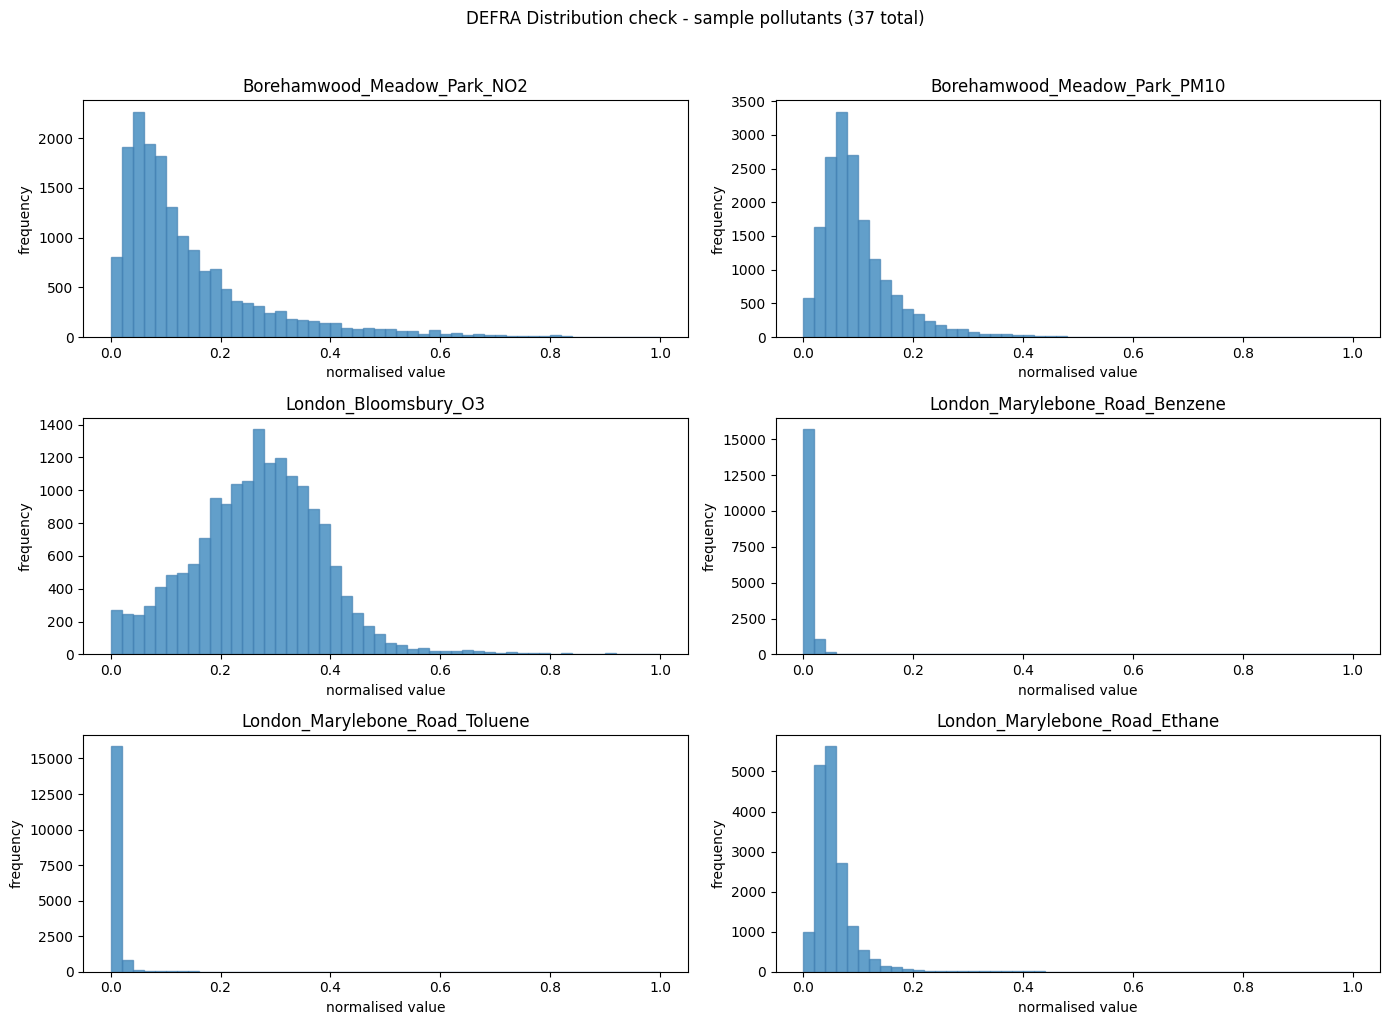

In [28]:
# Quick sanity check - sample of pollutants
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
axes = axes.flatten()

# Sample different pollutant types
sample_pollutants = ['NO2', 'PM10', 'O3', 'Benzene', 'Toluene', 'Ethane']

for i, poll in enumerate(sample_pollutants):
    poll_cols = [col for col in feature_names if poll in col]
    
    if poll_cols:
        col_name = poll_cols[0]
        col_idx = feature_names.index(col_name)
        
        axes[i].hist(X_train[:, -1, col_idx], bins=50, edgecolor='steelblue', alpha=0.7)
        axes[i].set_title(f'{col_name}')
        axes[i].set_xlabel('normalised value')
        axes[i].set_ylabel('frequency')
    else:
        axes[i].text(0.5, 0.5, f'No {poll} data', ha='center', va='center')
        axes[i].set_title(f'{poll} - not available')

plt.suptitle('DEFRA Distribution check - sample pollutants (37 total)', y=1.02)
plt.tight_layout()
plt.savefig(visualisation_path / 'defra_37pollutant_distributions.png', dpi=150)
plt.show()

### Complete!

**Summary:**

- Loaded DEFRA data from optimised folder
- Kept ALL 37 pollutants (regulatory + VOCs)
- Applied tiered missing value handling
- Created sequences for CNN (3D) and RF (2D)
- Saved all arrays and metadata

**Next steps:**
1. Compare with 6-pollutant version to see if extra features help
2. Run RF and CNN training on this dataset
3. Analyse which pollutants contribute most to predictions